# task1 PyTorch的基本概念

## 安装

参考
[WIn10+Anaconda 环境下安装 PyTorch 避坑指南](https://blog.csdn.net/red_stone1/article/details/86669362)

```
# Python 3.6
pip3 install https://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-win_amd64.whl
pip3 install torchvision
```

虽然本来安装了anaconda，但是最后还是用pip安装成功的，不过没有出现参考文章中import torchvision 报错的情况，直接就成功了

## 简单操作

In [1]:
import torch
import torchvision
from __future__ import print_function

创建一个没有初始化的5*3矩阵：

In [2]:
x = torch.empty(5, 3)
print(x)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.3340e-42, 0.0000e+00],
        [0.0000e+00, 4.4810e+30, 0.0000e+00]])


实现一个只有输入层、单隐藏层、输出层的一个神经网络。假设样本数为64个，输入维度为1000，隐藏层为100，输出层为10。

参考[简单神经网络在Numpy和Pytorch上的实现](https://blog.csdn.net/herosunly/article/details/88949873)

In [3]:
num_samples = 64 # N
dim_in, dim_hid, dim_out = 1000, 100, 10  # IN H OUT
x = torch.randn(num_samples, dim_in)  #  N * IN
y = torch.randn(num_samples, dim_out) #  N * OUT

w1 = torch.randn(dim_in, dim_hid)     # IN * H
w2 = torch.randn(dim_hid, dim_out)    #  H * OUT

eta = 1e-6
for i in range(100):
    #Forward pass
    h = x @ w1                              # N * H
    h_relu = h.clamp(min = 0)               # N * H
    y_pred = h_relu @ w2                    # N * OUT

    #Loss
    loss = (y_pred - y).pow(2).sum().item()
    print('times is {}, loss is {}'.format(i, loss))

    #Backward pass
    grad_y_pred = 2.0 * (y_pred - y)        # N * OUT
    grad_w2 = (h_relu.t()) @ (grad_y_pred) #H * OUT = (H * N) * (N * OUT)，其中(H * N) = (N * H).T

    grad_h_relu = grad_y_pred @ ((w2.t()))# N * H = (N * OUT) * (OUT * H)，其中(OUT * H) = (H * OUT).T
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0

    grad_w1 = (x.t()) @ (grad_h)  # IN * H = （IN * N） * (N * H)

    w1 = w1 - eta * grad_w1
    w2 = w2 - eta * grad_w2

times is 0, loss is 27274294.0
times is 1, loss is 20173400.0
times is 2, loss is 16992264.0
times is 3, loss is 14946633.0
times is 4, loss is 12974883.0
times is 5, loss is 10754442.0
times is 6, loss is 8442926.0
times is 7, loss is 6302774.0
times is 8, loss is 4544051.0
times is 9, loss is 3216244.0
times is 10, loss is 2275754.25
times is 11, loss is 1629398.875
times is 12, loss is 1192330.25
times is 13, loss is 895365.75
times is 14, loss is 691564.0
times is 15, loss is 548771.9375
times is 16, loss is 446226.25
times is 17, loss is 370414.625
times is 18, loss is 312785.09375
times is 19, loss is 267841.96875
times is 20, loss is 231970.3125
times is 21, loss is 202714.015625
times is 22, loss is 178443.796875
times is 23, loss is 158024.484375
times is 24, loss is 140630.625
times is 25, loss is 125667.0078125
times is 26, loss is 112697.765625
times is 27, loss is 101390.515625
times is 28, loss is 91466.4375
times is 29, loss is 82720.1328125
times is 30, loss is 74992.71

# task2 设立计算图并自动计算

## 一、线性回归 y = w1*x1 + w2*x2

In [4]:
w1 = 4
w2 = -3

${loss}=\frac{1}{2n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2}$

$\frac{dloss}{d w_{1}}=\frac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right) \cdot x_{1_{i}}$

$\frac{dloss}{d w_{2}}=\frac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right) \cdot x_{2_{i}}$

### 1、numpy方式

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
x_data = np.array([[1,2,3],
                   [3,1,2]])
y_data = w1 * x_data[0] + w2 * x_data[1]

In [7]:
y_data

array([-5,  5,  6])

In [8]:
epochs = 10
rate = 0.1
w1_ = 0
w2_ = 0
cost = []

In [9]:
for epoch in range(epochs):
    y_ = w1_ * x_data[0] + w2_ * x_data[1]
    #print(y_)
    #计算损失
    loss = np.average((y_ - y_data)**2)/2.0
    cost.append(loss)
    
    #计算梯度
    dw1 = (y_ - y_data) @ x_data[0].T/(x_data.shape[1])
    dw2 = (y_ - y_data) @ x_data[1].T/(x_data.shape[1])
    #print(dw1,dw2)
    #参数更新
    w1_ = w1_ - rate * dw1
    w2_ = w2_ - rate * dw2
    print(w1_,w2_)

0.7666666666666667 0.06666666666666667
1.1511111111111112 -0.17888888888888888
1.4461851851851852 -0.4508148148148148
1.7032641975308642 -0.7040358024691358
1.9332206995884773 -0.9333493004115226
2.1399457832647464 -1.1399672167352537
2.3259590638774577 -1.3259626361225423
2.4933644673129094 -1.4933650626870905
2.6440282388854848 -1.6440283381145149
2.7796254513809138 -1.7796254679190857


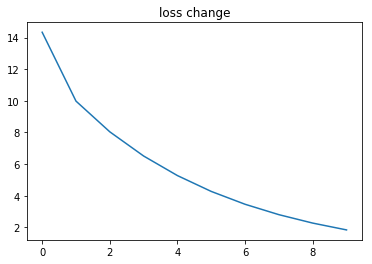

In [10]:
plt.figure()
plt.plot(range(epochs), cost)
plt.title(u"loss change")
plt.show()

### 2、torch 方式

In [11]:
from torch.autograd import Variable

In [12]:
torch.manual_seed(2)

In [13]:
x_data = Variable(torch.Tensor([[1.0,3.0],[2.0,1.0],[3.0,2.0]]))
y_data = Variable(torch.Tensor([[-5.0],[5.0],[6.0]]))

In [14]:
x_data

tensor([[1., 3.],
        [2., 1.],
        [3., 2.]])

In [15]:
y_data

tensor([[-5.],
        [ 5.],
        [ 6.]])

In [16]:
epochs = 10
rate = 0.1
w = Variable(torch.FloatTensor([[0],[0]]))
w.requires_grad_(True)
cost = []

In [17]:
for epoch in range(epochs):
    y_ = x_data.mm(w)
    #print(y_)
    loss = ((y_ - y_data)**2).mean()/2.0
    cost.append(float(loss.data))
    loss.backward()
    w.data = w.data - rate * w.grad.data
    
    #print(w.grad.data)
    #这一步很关键，必须清零，因为 .grad这个属性值是累加的
    w.grad.data.zero_()
    print(w.data)

tensor([[0.7667],
        [0.0667]])
tensor([[ 1.1511],
        [-0.1789]])
tensor([[ 1.4462],
        [-0.4508]])
tensor([[ 1.7033],
        [-0.7040]])
tensor([[ 1.9332],
        [-0.9333]])
tensor([[ 2.1399],
        [-1.1400]])
tensor([[ 2.3260],
        [-1.3260]])
tensor([[ 2.4934],
        [-1.4934]])
tensor([[ 2.6440],
        [-1.6440]])
tensor([[ 2.7796],
        [-1.7796]])


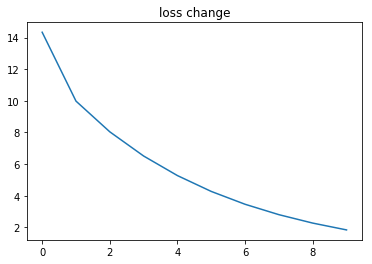

In [18]:
plt.figure()
plt.plot(range(epochs), cost)
plt.title(u"loss change")
plt.show()

# task3 PyTorch实现Logistic regression

参考[Pytorch实现逻辑回归](https://blog.csdn.net/herosunly/article/details/89130368)

## 公式推导

$\hat{y}_{i}=\frac{1}{1+e^{-\left(w \cdot x_{i}+b\right)}}$

极大似然思想

$maxL=\prod_{i=1}^{N} \hat{y}_{i}^{y_{i}} \cdot\left(1-\hat{y}_{i}\right)^{\left(1-{y_{i}}\right)}$

$max\ln L=\sum_{i=1}^{N} y_{i} \ln \hat{y}_{i}+\left(1-y_{i}\right) \ln \left(1-\hat{y}_{i}\right)$

$\max \ln L=\min(-\ln L)$

## 一、PyTorch基础实现代码

In [150]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

seed = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [86]:
x_data = torch.Tensor([[0.1,0.3],[0.2,0.6],[0.2,0.8],[0.4,0.7],[0.4,0.2],[0.6,0.4],[0.6,0.6],[0.8,0.8],[1,0.4]])
y_data = torch.Tensor([[1],[1],[1],[1],[0],[0],[0],[0],[0]])

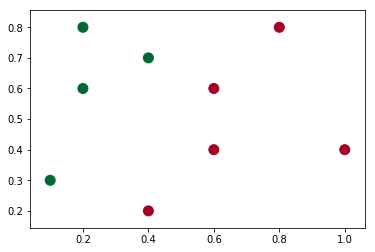

In [92]:
plt.figure()
plt.scatter(x_data.data.numpy()[:, 0], x_data.data.numpy()[:, 1], c=y_data.data.numpy().reshape(1,9)[0], s=100, cmap='RdYlGn')
plt.show()

#### 用torch来构造随机数据

In [180]:
center_data = torch.ones(100, 2)
x0 = torch.normal(mean=center_data+2, std=1) #得到正太数据
y0 = torch.zeros(center_data.shape[0],1) #设定为 0 label
x1 = torch.normal(mean=center_data-2, std=1) #得到正太数据
y1 = torch.ones(center_data.shape[0],1) #设定为 1 label
x_data = torch.cat((x0,x1),0).type(torch.FloatTensor)
y_data = torch.cat((y0,y1),0).type(torch.FloatTensor)

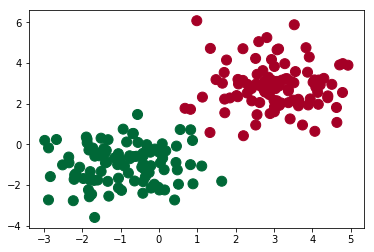

In [181]:
plt.figure()
plt.scatter(x_data.data.numpy()[:, 0], x_data.data.numpy()[:, 1], c=y_data.data.numpy().reshape(1,2*center_data.shape[0])[0], s=100, cmap='RdYlGn')
plt.show()

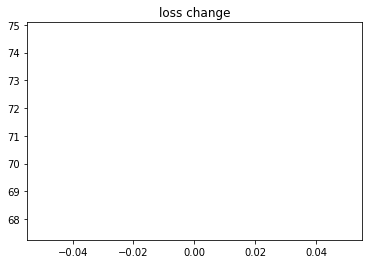

In [196]:
dim_in = x_data.shape[1] # IN
dim_out = 1  # OUT
x_data = Variable(x_data)
y_data = Variable(y_data)
w = torch.randn(dim_in, dim_out, requires_grad=True)     # IN * OUT
b = torch.randn(dim_out, requires_grad=True)                  #bias，偏置项

eta = 0.1
epochs = 100
loss_ = []
w_ = []
for epoch in range(epochs):
    #Forward pass
    w_.append(w.data)
    h = x_data @ w + b  
    fun = nn.Sigmoid()
    y_pred = fun(h)                                    #sigmod激活函数
    #print(y_pred)
    #Loss
    loss = -torch.sum(y_data * torch.log(y_pred) + (1 - y_data) * torch.log(1 - y_pred)) 
    #print('epoch is {}, loss is {}'.format(epoch, loss.item()))
    loss_.append(float(loss.data))
    loss.backward()

    w.data = w.data - eta * w.grad.data
    b.data = b.data - eta * b.grad.data
    
    w.grad.data.zero_()
    b.grad.data.zero_()
    
plt.figure()
plt.plot(range(epochs), loss_)
plt.title(u"loss change")
plt.show()

In [198]:
w_

[tensor([[-0.6953],
         [-0.3675]]), tensor([[-3.9381],
         [-4.6498]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [n

In [197]:
loss_

[71.1711654663086,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

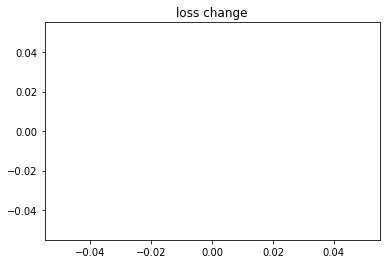

In [183]:
dim_in = x_data.shape[1] # IN
dim_out = 1  # OUT

#w = torch.randn(dim_in, dim_out, requires_grad=True)     # IN * OUT
b = torch.randn(dim_out, requires_grad=True)                  #bias，偏置项

w = Variable(torch.FloatTensor([[10],[-4]]))
w.requires_grad_(True)
eta = 0.1
epochs = 1000
loss_ = []
w_ = []
for epoch in range(epochs):
    #Forward pass
    w_.append(w.data)
    h = x_data @ w + b                                                    
    y_pred = 1 / (1 + torch.exp(-h))                                    #sigmod激活函数

    #Loss
    loss = -torch.sum(y_data * torch.log(y_pred) + (1 - y_data) * torch.log(1 - y_pred)) 
    #print('epoch is {}, loss is {}'.format(epoch, loss.item()))
    loss_.append(float(loss.data))
    loss.backward()

    w.data = w.data - eta * w.grad.data
    b.data = b.data - eta * b.grad.data
    
    w.grad.data.zero_()
    b.grad.data.zero_()
    
plt.figure()
plt.plot(range(epochs), loss_)
plt.title(u"loss change")
plt.show()

In [27]:
loss_[-1]

0.5120936632156372

In [28]:
w_

[tensor([[10.],
         [-4.]]), tensor([[ 9.6937],
         [-4.1385]]), tensor([[ 9.3980],
         [-4.2512]]), tensor([[ 9.1132],
         [-4.3407]]), tensor([[ 8.8395],
         [-4.4094]]), tensor([[ 8.5770],
         [-4.4597]]), tensor([[ 8.3257],
         [-4.4937]]), tensor([[ 8.0856],
         [-4.5129]]), tensor([[ 7.8566],
         [-4.5188]]), tensor([[ 7.6383],
         [-4.5128]]), tensor([[ 7.4301],
         [-4.4961]]), tensor([[ 7.2310],
         [-4.4700]]), tensor([[ 7.0402],
         [-4.4358]]), tensor([[ 6.8566],
         [-4.3948]]), tensor([[ 6.6794],
         [-4.3481]]), tensor([[ 6.5075],
         [-4.2965]]), tensor([[ 6.3402],
         [-4.2411]]), tensor([[ 6.1768],
         [-4.1825]]), tensor([[ 6.0167],
         [-4.1214]]), tensor([[ 5.8595],
         [-4.0583]]), tensor([[ 5.7047],
         [-3.9936]]), tensor([[ 5.5520],
         [-3.9277]]), tensor([[ 5.4011],
         [-3.8608]]), tensor([[ 5.2519],
         [-3.7933]]), tensor([[ 5.1042],
    

In [29]:
w

tensor([[-14.9018],
        [  7.9678]], requires_grad=True)

In [30]:
b

tensor([1.9999], requires_grad=True)

In [31]:
line_x = np.arange(10)/10
line_y = (-w.data.numpy()[0]*line_x-b.data.numpy()[0])/w.data.numpy()[1]

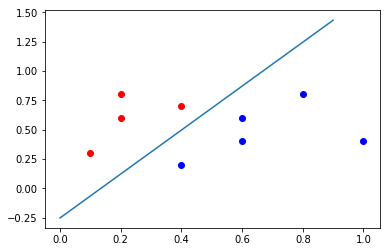

In [32]:
plt.figure()
plt.scatter(x_data.numpy()[:4,0],x_data.numpy()[:4,1] , marker='o', color='red')
plt.scatter(x_data.numpy()[4:,0],x_data.numpy()[4:,1] , marker='o', color='blue')
plt.plot(line_x,line_y)
plt.show()

## 用PyTorch类实现Logistic regression,torch.nn.module写网络结构

In [106]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(dim_in, dim_out)
    
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [107]:
model = Model()

In [108]:
# 定义 Loss 和 优化方法
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [109]:
tmp_test = Variable(torch.Tensor([[0, 1.0]]))
tmp_pred = model(tmp_test)
print("predict (before train)",tmp_test, "is" , 1 / (1 + np.exp(-float(tmp_pred.data))) >0.5)

predict (before train) tensor([[0., 1.]]) is False


In [110]:
epochs = 1000
loss_ = []
for epoch in range(epochs):
    # 计算 grads and cost
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    loss_.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #optimizer.zero_grad()

ValueError: Target size (torch.Size([200])) must be the same as input size (torch.Size([200, 1]))

In [38]:
tmp_test = Variable(torch.Tensor([[0, 1.0]]))
tmp_pred = model(tmp_test)
print("predict (after train)",tmp_test, "is" , 1 / (1 + np.exp(-float(tmp_pred.data))) >0.5)

predict (after train) tensor([[0., 1.]]) is True


In [39]:
param_ = []
for param in model.parameters():
    print(param.data)
    param_.append(param.data.numpy())

tensor([[-5.6192,  2.3973]])
tensor([0.9659])


In [40]:
w1 = param_[0][0][0]
w2 = param_[0][0][1]
b = param_[1][0]

In [41]:
line_x = np.arange(10)/10
line_y = (-w1*line_x-b)/w2

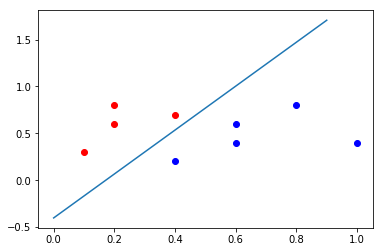

In [42]:
plt.figure()
plt.scatter(x_data.numpy()[:4,0],x_data.numpy()[:4,1] , marker='o', color='red')
plt.scatter(x_data.numpy()[4:,0],x_data.numpy()[4:,1] , marker='o', color='blue')
plt.plot(line_x,line_y)
plt.show()

In [43]:
n_data = torch.ones(10, 2)

In [48]:
n_data+2

tensor([[3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.]])

In [45]:
x0 = torch.normal(2*n_data, 1)

In [46]:
x0

tensor([[1.3182, 1.4088],
        [2.2738, 1.0351],
        [1.7007, 3.8793],
        [1.9279, 2.1578],
        [1.2265, 2.1991],
        [2.0457, 2.1530],
        [4.6891, 1.8890],
        [2.2927, 1.8422],
        [1.9712, 4.3571],
        [0.9627, 3.5748]])